这个test是为了验证不同normalized方法对于计算KR和GR的影响，并找到最合适的方法

In [ ]:
#使用最大值和最小值进行缩放到-1到1范围内


In [1]:
# import necessary libraries
import os
import torch 
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
import tqdm as tqdm
import pickle



from pathlib import Path


CANDIDATES = [
    
    Path(r"C:\Users\tom\Desktop\Repository"),
    Path(r"C:\Users\Chen\Desktop\Repository"),
    Path(r"/Users/vvvp./Desktop"),
]
searchpaths = [p for p in CANDIDATES if p.exists()]

#tuple of repos
repos = ('machine_learning_library',)





import sys
import os
# In Jupyter notebooks, __file__ is not defined. Use the current working directory instead.
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import repo_tools
repo_tools.repos_path_finder(searchpaths, repos)
from spnc import spnc_anisotropy
import spnc_ml as ml
from deterministic_mask import fixed_seed_mask, max_sequences_mask

from single_node_res import single_node_reservoir
import ridge_regression as RR
from linear_layer import *
from mask import binary_mask
from utility import *
from NARMA10 import NARMA10
from datasets.load_TI46_digits import *
import datasets.load_TI46 as TI46
from sklearn.metrics import classification_report
from formal_Parameter_Dynamics_Preformance import *


In [2]:
# 构建储层对象
class ReservoirParams:
    def __init__(self, **kwargs):
            # Reservoir parameters 
            self.h = 0.4
            self.theta_H = 90
            self.k_s_0 = 0
            self.phi = 45
            self.beta_prime = 35.13826524755751

            # Network parameters 
            self.Nvirt = 50
            self.m0 = 0.005288612874870094
            self.bias = True
            self.Nwarmup = 0
            self.verbose_repr = False

            self.params = {
                'theta': 0.34142235979698393,
                'gamma': 0.069274461903986,
                'delay_feedback': 0,
                'Nvirt': self.Nvirt,
                'length_warmup': self.Nwarmup,
                'warmup_sample': self.Nwarmup * self.Nvirt,
                'voltage_noise': False,
                'seed_voltage_noise': 1234,
                'delta_V': 0.1,
                'johnson_noise': False,
                'seed_johnson_noise': 1234,
                'mean_johnson_noise': 0.0000,
                'std_johnson_noise': 0.00001,
                'thermal_noise': False,
                'seed_thermal_noise': 1234,
                'lambda_ou': 1.0,
                'sigma_ou': 0.1
        }

            for key in ['h', 'theta_H', 'k_s_0', 'phi', 'beta_prime', 'Nvirt', 'm0', 'bias', 'Nwarmup']:
                if key in kwargs:
                    setattr(self, key, kwargs[key])

            
            if 'params' in kwargs and isinstance(kwargs['params'], dict):
                self.params.update(kwargs['params'])

    
    def update_params(self, **kwargs):
        for key, value in kwargs.items():
            if hasattr(self, key):
                setattr(self, key, value)
            if key in self.params:
                self.params[key] = value
            if not hasattr(self, key) and key not in self.params:
                raise AttributeError(f"ReservoirParams has no attribute or param key '{key}'")
            
    def print_params(self, verbose=False):
        if not verbose:
            print(f"ReservoirParams(h={self.h}, beta_prime={self.beta_prime}, Nvirt={self.Nvirt})")
        else:
            print(f"ReservoirParams detailed info:")
            print(f"  h = {self.h}")
            print(f"  theta_H = {self.theta_H}")
            print(f"  k_s_0 = {self.k_s_0}")
            print(f"  phi = {self.phi}")
            print(f"  beta_prime = {self.beta_prime}")
            print(f"  Nvirt = {self.Nvirt}")
            print(f"  m0 = {self.m0}")
            print(f"  bias = {self.bias}")
            print("  params dictionary:")
            for k, v in self.params.items():
                print(f"    {k}: {v}")

In [3]:
def gen_KR_GR_input(Nreadouts, Nwash=10, seed=1234):
    # set seed
    np.random.seed(seed)
    # generate KR inputs
    KR_inputs = np.random.ranf((Nreadouts, Nwash))
    # 打印KR_inputs
    # print('KR_inputs',KR_inputs)
    # print('shape of KR_inputs',np.shape(KR_inputs))

    GR_inputs = np.tile(np.random.ranf((10)), (Nreadouts,1))
    # print('GR_inputs',GR_inputs)
    # print('shape of GR_inputs',np.shape(GR_inputs))

    all_inputs = np.concatenate((KR_inputs, GR_inputs), axis=1)
    # 打印all_inputs的前10个元素
    # print('all_inputs',all_inputs)
    # print('shape of all_inputs',np.shape(all_inputs))
    return all_inputs


def Evaluate_KR_GR(states, Nreadouts, threshold=0.1):
    GR_states = states[:,-1,:]
    # print('GR_states',GR_states)
    # print('shape of GR_states',np.shape(GR_states))
    '''
    Change the last 7 columns to GR states, the rest are KR states
    '''
    KR_states = states[:,-11,:]
    # print('KR_states',KR_states)
    # print('shape of KR_states',np.shape(KR_states)) 
    
    uGR, sGR, vGR = np.linalg.svd(GR_states)
    uKR, sKR, vKR = np.linalg.svd(KR_states)
    KR = 0
    GR = 0
    for i in range(Nreadouts):
        if sGR[i]>threshold:
            GR += 1
        if sKR[i]>threshold:
            KR += 1
    return KR, GR, GR_states, KR_states,sGR,sKR

# ------------------------ Reservoir ----------------------------


In [4]:
def evaluate_KRandGR(reservoir_params, Nreadouts=50, Nwash=10, **kwargs):
    
    Nreadouts= reservoir_params.Nvirt

    inputs = gen_KR_GR_input(Nreadouts, Nwash, seed=1234)   # <--- 用Nreadouts
    outputs = []
    for input_row in inputs:
        input_row = input_row.reshape(-1, 1)
        spn = spnc_anisotropy(reservoir_params.h, reservoir_params.theta_H,
                              reservoir_params.k_s_0, reservoir_params.phi,
                              reservoir_params.beta_prime, restart=True)
        transforms = spn.gen_signal_slow_delayed_feedback
        output = RunSpnc(input_row, 1, 1, reservoir_params.Nvirt,
                         reservoir_params.m0, transforms, reservoir_params.params, fixed_mask=True, seed_mask=1234)
        outputs.append(output)
    States = np.stack(outputs, axis=0)
    if kwargs.get('minmax', False):
        States_min = np.amin(States)
        States_max = np.amax(States)
        Normalized_States = 2 * (States - States_min) / (States_max - States_min) - 1
    if kwargs.get('max', False):
        Normalized_States = States/np.amax(States)
    if kwargs.get('without', False):
        Normalized_States = States
    if kwargs.get('minmax01', False):
        States_min = np.amin(States)
        States_max = np.amax(States)
        Normalized_States = (States - States_min) / (States_max - States_min)
    KR, GR, GR_states, KR_states,sGR,sKR = Evaluate_KR_GR(Normalized_States, Nreadouts, threshold=0.1)  # <--- 用Nreadouts
    return KR, GR, GR_states, KR_states,sGR,sKR, outputs, States, Normalized_States


以下cell是bestCQ为储层的测试

In [43]:
# 直观地对比bestMC和bestCQ的差异
params_bestCQ = ReservoirParams(
            h=0.4, m0=0.00636114267244565, Nvirt=200, beta_prime=27.5044435911311,
            params={'theta': 0.01, 'gamma': 0.308759977781925, 'Nvirt': 200}
        )

params_bestMC = ReservoirParams(
            h=0.4, m0=0.008, Nvirt=200, beta_prime=	50.0,
            params={'theta': 0.156493838858319, 'gamma': 0.0460842584494091, 'Nvirt': 200}
        )  
print('#########################')
print('bestCQ')       
KR_bestCQ, GR_bestCQ, GR_states_bestCQ, KR_states_bestCQ,sGR_bestCQ,sKR_bestCQ, outputs_bestCQ, States_bestCQ, Normalized_States_bestCQ = evaluate_KRandGR(params_bestCQ, threshold=0.1,minmax01=True)
print('KR_bestCQ, GR_bestCQ', KR_bestCQ, GR_bestCQ)
print('#########################')

print('#########################')
print('bestMC')
KR_bestMC, GR_bestMC, GR_states_bestMC, KR_states_bestMC,sGR_bestMC,sKR_bestMC, outputs_bestMC, States_bestMC, Normalized_States_bestMC= evaluate_KRandGR(params_bestMC, threshold=0.1,minmax01=True)
print('KR_bestMC, GR_bestMC', KR_bestMC, GR_bestMC)
print('#########################')

#########################
bestCQ
KR_bestCQ, GR_bestCQ 3 1
#########################
#########################
bestMC
KR_bestMC, GR_bestMC 6 3
#########################


shape of outputs_bestCQ (200, 20, 200)
(20, 200)
max of outputs_bestCQ_array 0.005080107141475998
min of outputs_bestCQ_array -0.867927831808759
max of outputs_bestMC_array 0.15819706530320526
min of outputs_bestMC_array -0.17288046298322818


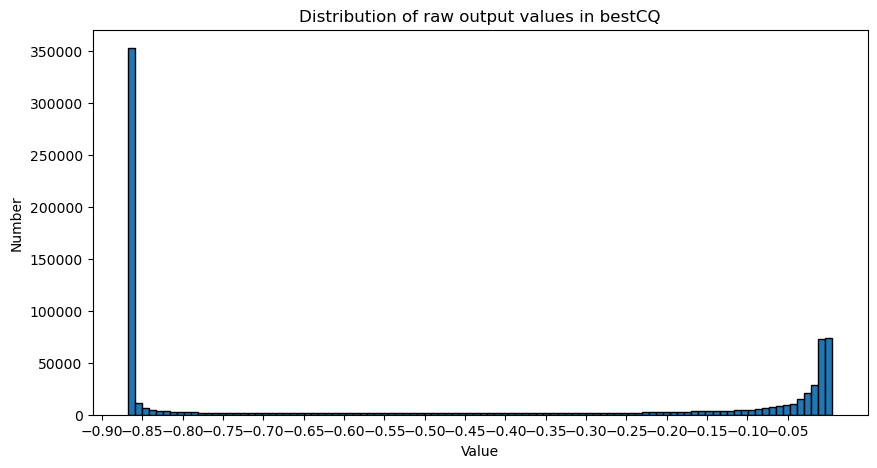

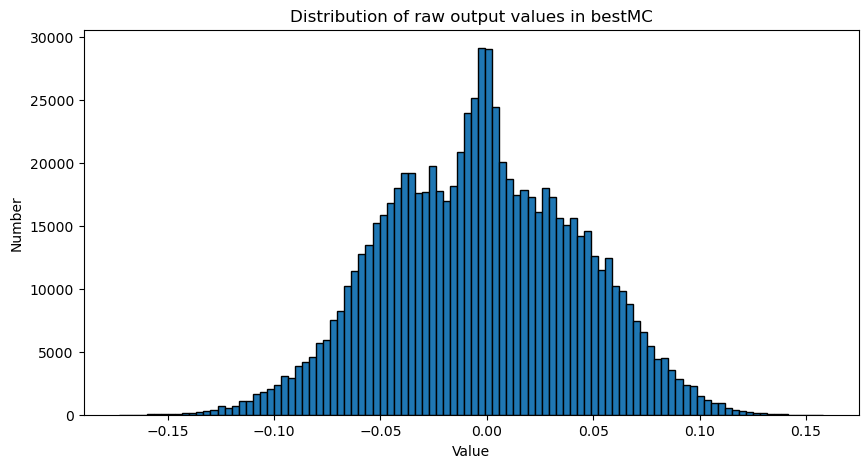

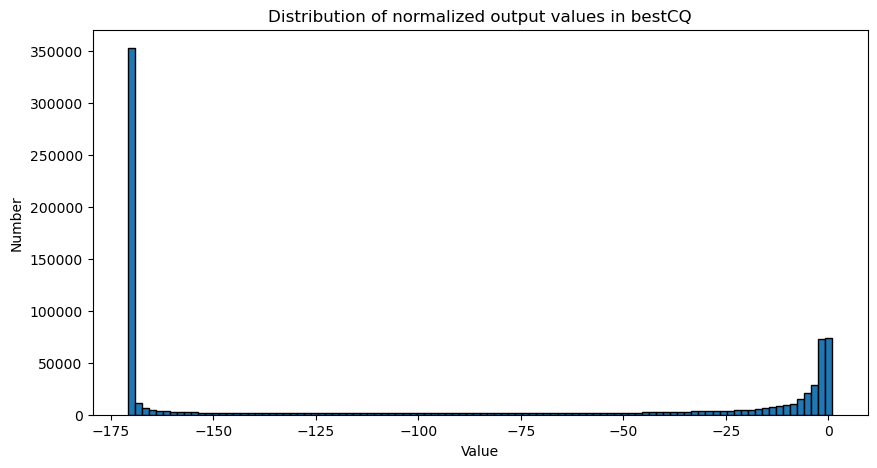

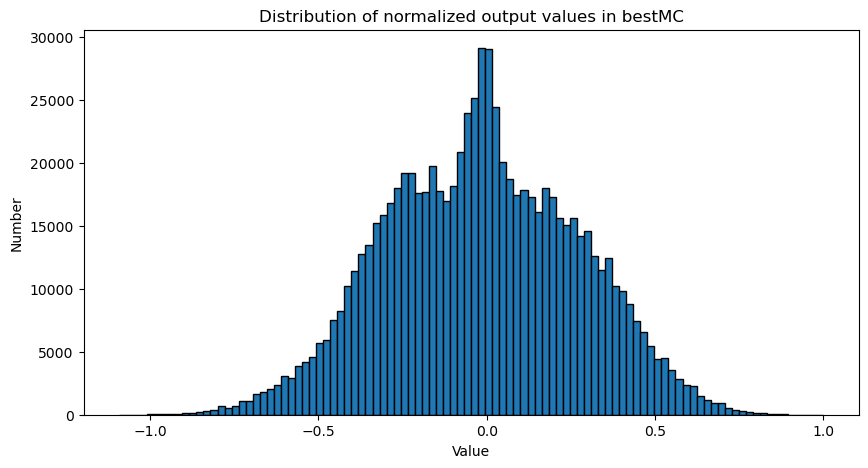

In [34]:
print('shape of outputs_bestCQ',np.shape(outputs_bestCQ))
print(np.shape(outputs_bestCQ[1]))

# 我想了解outputs_bestCQ中的元素数值分布，请用柱状图来表示元素的数值分布
# 将list转成numpy数组
outputs_bestCQ_array = np.array(outputs_bestCQ)
outputs_bestMC_array = np.array(outputs_bestMC)

# 打印出outputs_bestCQ_array的最大值和最小值
print('max of outputs_bestCQ_array',np.max(outputs_bestCQ_array))
print('min of outputs_bestCQ_array',np.min(outputs_bestCQ_array))

# 打印出outputs_bestMC_array的最大值和最小值
print('max of outputs_bestMC_array',np.max(outputs_bestMC_array))
print('min of outputs_bestMC_array',np.min(outputs_bestMC_array))



plt.figure(figsize=(10, 5))
plt.hist(outputs_bestCQ_array.flatten(), bins=100, edgecolor='black')
plt.ylabel('Number')
plt.xlabel('Value')
# x轴的刻度尺再细一点
plt.xticks(np.arange(-0.9, 0, 0.05))
plt.title('Distribution of raw output values in bestCQ')
plt.show()

plt.figure(figsize=(10, 5))
plt.hist(outputs_bestMC_array.flatten(), bins=100, edgecolor='black')
plt.ylabel('Number')
plt.xlabel('Value')
plt.title('Distribution of raw output values in bestMC')
plt.show()


# States_bestCQ的分布
plt.figure(figsize=(10, 5))
plt.hist(Normalized_States_bestCQ.flatten(), bins=100, edgecolor='black')
plt.ylabel('Number')
plt.xlabel('Value')
plt.title('Distribution of normalized output values in bestCQ')
plt.show()

# States_bestMC的分布
plt.figure(figsize=(10, 5))
plt.hist(Normalized_States_bestMC.flatten(), bins=100, edgecolor='black')
plt.ylabel('Number')
plt.xlabel('Value')
plt.title('Distribution of normalized output values in bestMC')
plt.show()





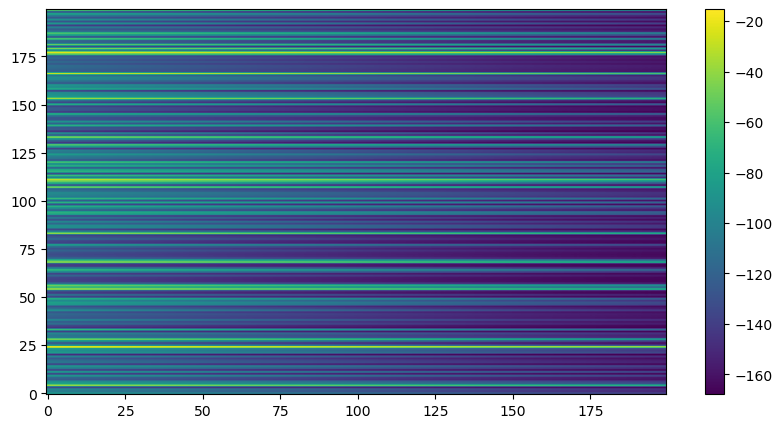

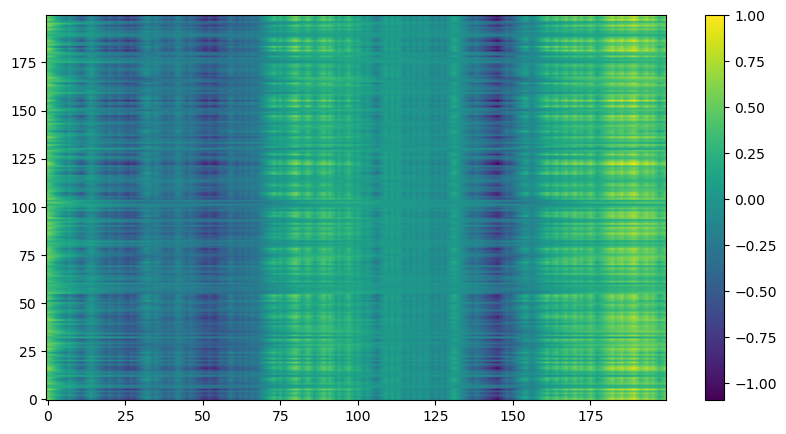

In [35]:
# 画一个原始热力图
plt.figure(figsize=(10, 5))
plt.imshow(KR_states_bestCQ, aspect='auto')
#翻转y轴
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(KR_states_bestMC, aspect='auto')
#翻转y轴
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

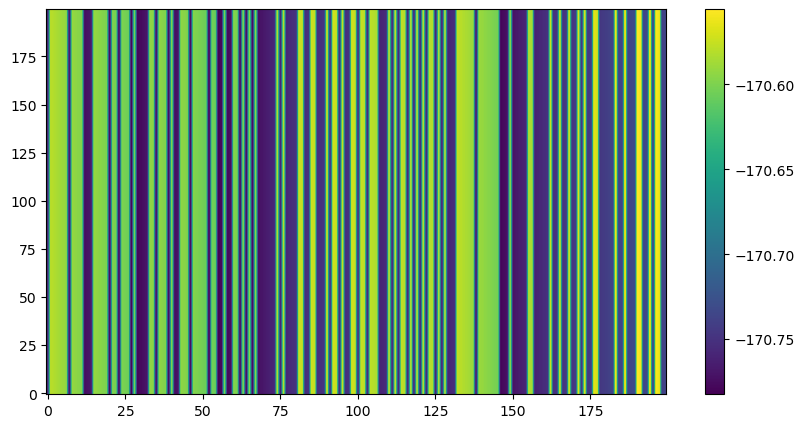

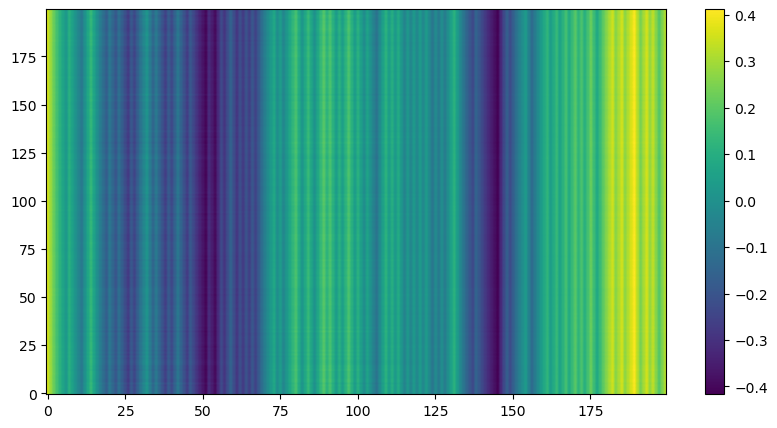

In [36]:
# 画一个原始热力图
plt.figure(figsize=(10, 5))
plt.imshow(GR_states_bestCQ, aspect='auto')
#翻转y轴
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(GR_states_bestMC, aspect='auto')
#翻转y轴
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

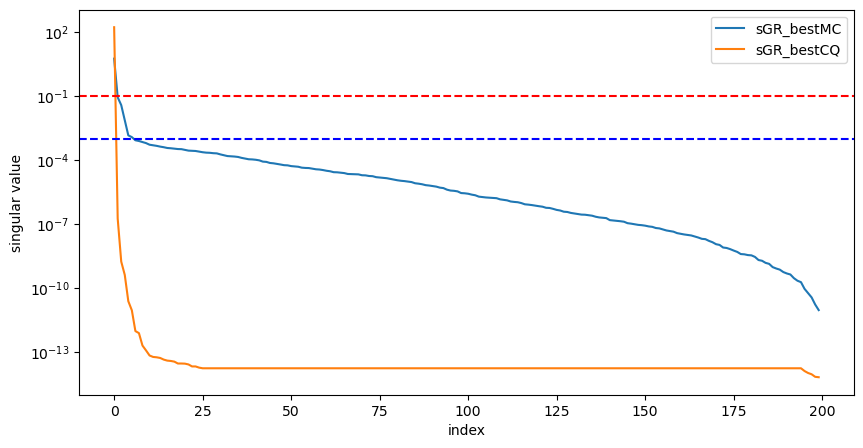

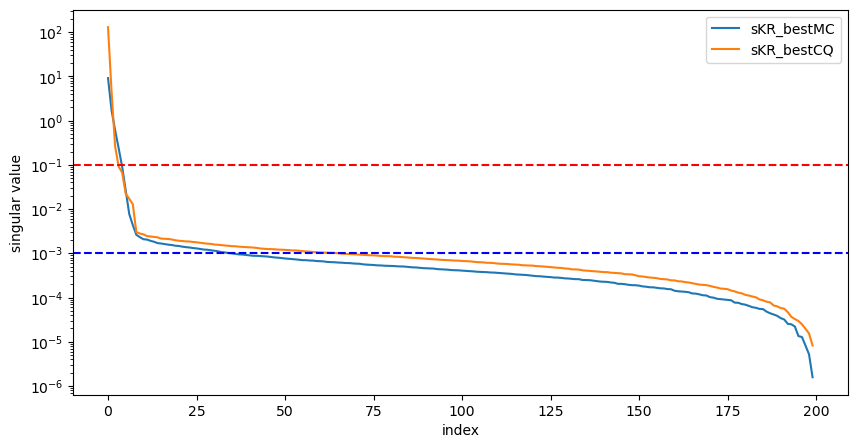

In [41]:
#查看下sGR和sKR
plt.figure(figsize=(10, 5))
# 使用直方图
plt.plot(sGR_bestMC,label='sGR_bestMC')
plt.plot(sGR_bestCQ,label='sGR_bestCQ')
plt.yscale('log')
# 画一个辅助线
plt.axhline(y=0.1, color='red', linestyle='--')
plt.axhline(y=0.001, color='blue', linestyle='--')
plt.ylabel('singular value')
plt.xlabel('index')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(sKR_bestMC,label='sKR_bestMC')
plt.plot(sKR_bestCQ,label='sKR_bestCQ')
plt.yscale('log')
plt.axhline(y=0.1, color='red', linestyle='--')
plt.axhline(y=0.001, color='blue', linestyle='--')
plt.ylabel('singular value')
plt.xlabel('index')
plt.legend()
plt.show()



In [44]:
# 将所有数据保存在一个文件中
with open('minmax01.pkl', 'wb') as f:
    pickle.dump({
        'KR_bestCQ': KR_bestCQ,
        'GR_bestCQ': GR_bestCQ,
        'KR_bestMC': KR_bestMC,
        'GR_bestMC': GR_bestMC,
        'GR_states_bestCQ': GR_states_bestCQ,
        'KR_states_bestCQ': KR_states_bestCQ,
        'GR_states_bestMC': GR_states_bestMC,
        'KR_states_bestMC': KR_states_bestMC,
        'sGR_bestCQ': sGR_bestCQ,
        'sKR_bestCQ': sKR_bestCQ,
        'sGR_bestMC': sGR_bestMC,
        'sKR_bestMC': sKR_bestMC,
        'outputs_bestCQ': outputs_bestCQ,
        'outputs_bestMC': outputs_bestMC,
        'States_bestCQ': States_bestCQ,
        'States_bestMC': States_bestMC,
        'Normalized_States_bestCQ': Normalized_States_bestCQ,
        'Normalized_States_bestMC': Normalized_States_bestMC,
    }, f)


引入另外两个储层作为对比

In [46]:
# 直观地对比bestMC和bestCQ的差异
params_good = ReservoirParams(
        h=0.4, m0=0.0516554082018051, Nvirt=200, beta_prime=	50.0,
        params={'theta': 0.2, 'gamma': 0.0480297911638143, 'Nvirt': 200}
    )
params_normal = ReservoirParams(
        h=0.4, m0=0.1825634100095717, Nvirt=200, beta_prime=	50.0,
        params={'theta': 0.2, 'gamma': 0.1451341063826008, 'Nvirt': 200}
    )
          
print('#########################')
print('good')       
KR_good, GR_good, GR_states_good, KR_states_good,sGR_good,sKR_good, outputs_good, States_good, Normalized_States_good = evaluate_KRandGR(params_good, threshold=0.1,max=True)
print('KR_good, GR_good', KR_good, GR_good)
print('#########################')

print('#########################')
print('normal')
KR_normal, GR_normal, GR_states_normal, KR_states_normal,sGR_normal,sKR_normal, outputs_normal, States_normal, Normalized_States_normal= evaluate_KRandGR(params_normal, threshold=0.1,max=True)
print('KR_normal, GR_normal', KR_normal, GR_normal)
print('#########################')

# 将所有数据保存在一个文件中
with open('max_good_normal.pkl', 'wb') as f:
    pickle.dump({
        'KR_good': KR_good,
        'GR_good': GR_good,
        'KR_normal': KR_normal,
        'GR_normal': GR_normal,
        'GR_states_good': GR_states_good,
        'KR_states_good': KR_states_good,
        'GR_states_normal': GR_states_normal,
        'KR_states_normal': KR_states_normal,
        'sGR_good': sGR_good,
        'sKR_good': sKR_good,
        'sGR_normal': sGR_normal,
        'sKR_normal': sKR_normal,
        'outputs_good': outputs_good,
        'outputs_normal': outputs_normal,
        'States_good': States_good,
        'States_normal': States_normal,
        'Normalized_States_good': Normalized_States_good,
        'Normalized_States_normal': Normalized_States_normal,
    }, f)

#########################
good
KR_good, GR_good 11 2
#########################
#########################
normal
KR_normal, GR_normal 78 25
#########################


In [47]:
# 直观地对比bestMC和bestCQ的差异
params_good = ReservoirParams(
        h=0.4, m0=0.0516554082018051, Nvirt=200, beta_prime=	50.0,
        params={'theta': 0.2, 'gamma': 0.0480297911638143, 'Nvirt': 200}
    )
params_normal = ReservoirParams(
        h=0.4, m0=0.1825634100095717, Nvirt=200, beta_prime=	50.0,
        params={'theta': 0.2, 'gamma': 0.1451341063826008, 'Nvirt': 200}
    )
          
print('#########################')
print('good')       
KR_good, GR_good, GR_states_good, KR_states_good,sGR_good,sKR_good, outputs_good, States_good, Normalized_States_good = evaluate_KRandGR(params_good, threshold=0.1,minmax=True)
print('KR_good, GR_good', KR_good, GR_good)
print('#########################')

print('#########################')
print('normal')
KR_normal, GR_normal, GR_states_normal, KR_states_normal,sGR_normal,sKR_normal, outputs_normal, States_normal, Normalized_States_normal= evaluate_KRandGR(params_normal, threshold=0.1,minmax=True)
print('KR_normal, GR_normal', KR_normal, GR_normal)
print('#########################')

# 将所有数据保存在一个文件中
with open('minmax_good_normal.pkl', 'wb') as f:
    pickle.dump({
        'KR_good': KR_good,
        'GR_good': GR_good,
        'KR_normal': KR_normal,
        'GR_normal': GR_normal,
        'GR_states_good': GR_states_good,
        'KR_states_good': KR_states_good,
        'GR_states_normal': GR_states_normal,
        'KR_states_normal': KR_states_normal,
        'sGR_good': sGR_good,
        'sKR_good': sKR_good,
        'sGR_normal': sGR_normal,
        'sKR_normal': sKR_normal,
        'outputs_good': outputs_good,
        'outputs_normal': outputs_normal,
        'States_good': States_good,
        'States_normal': States_normal,
        'Normalized_States_good': Normalized_States_good,
        'Normalized_States_normal': Normalized_States_normal,
    }, f)

#########################
good
KR_good, GR_good 11 2
#########################
#########################
normal
KR_normal, GR_normal 78 25
#########################


In [48]:
# 直观地对比bestMC和bestCQ的差异
params_good = ReservoirParams(
        h=0.4, m0=0.0516554082018051, Nvirt=200, beta_prime=	50.0,
        params={'theta': 0.2, 'gamma': 0.0480297911638143, 'Nvirt': 200}
    )
params_normal = ReservoirParams(
        h=0.4, m0=0.1825634100095717, Nvirt=200, beta_prime=	50.0,
        params={'theta': 0.2, 'gamma': 0.1451341063826008, 'Nvirt': 200}
    )
          
print('#########################')
print('good')       
KR_good, GR_good, GR_states_good, KR_states_good,sGR_good,sKR_good, outputs_good, States_good, Normalized_States_good = evaluate_KRandGR(params_good, threshold=0.1,minmax01=True)
print('KR_good, GR_good', KR_good, GR_good)
print('#########################')

print('#########################')
print('normal')
KR_normal, GR_normal, GR_states_normal, KR_states_normal,sGR_normal,sKR_normal, outputs_normal, States_normal, Normalized_States_normal= evaluate_KRandGR(params_normal, threshold=0.1,minmax01=True)
print('KR_normal, GR_normal', KR_normal, GR_normal)
print('#########################')

# 将所有数据保存在一个文件中
with open('minmax01_good_normal.pkl', 'wb') as f:
    pickle.dump({
        'KR_good': KR_good,
        'GR_good': GR_good,
        'KR_normal': KR_normal,
        'GR_normal': GR_normal,
        'GR_states_good': GR_states_good,
        'KR_states_good': KR_states_good,
        'GR_states_normal': GR_states_normal,
        'KR_states_normal': KR_states_normal,
        'sGR_good': sGR_good,
        'sKR_good': sKR_good,
        'sGR_normal': sGR_normal,
        'sKR_normal': sKR_normal,
        'outputs_good': outputs_good,
        'outputs_normal': outputs_normal,
        'States_good': States_good,
        'States_normal': States_normal,
        'Normalized_States_good': Normalized_States_good,
        'Normalized_States_normal': Normalized_States_normal,
    }, f)

#########################
good
KR_good, GR_good 9 2
#########################
#########################
normal
KR_normal, GR_normal 59 20
#########################


In [ ]:
# 直观地对比bestMC和bestCQ的差异
params_good = ReservoirParams(
        h=0.4, m0=0.0516554082018051, Nvirt=200, beta_prime=	50.0,
        params={'theta': 0.2, 'gamma': 0.0480297911638143, 'Nvirt': 200}
    )
params_normal = ReservoirParams(
        h=0.4, m0=0.1825634100095717, Nvirt=200, beta_prime=	50.0,
        params={'theta': 0.2, 'gamma': 0.1451341063826008, 'Nvirt': 200}
    )
          
print('#########################')
print('good')       
KR_good, GR_good, GR_states_good, KR_states_good,sGR_good,sKR_good, outputs_good, States_good, Normalized_States_good = evaluate_KRandGR(params_good, threshold=0.1,without=True)
print('KR_good, GR_good', KR_good, GR_good)
print('#########################')

print('#########################')
print('normal')
KR_normal, GR_normal, GR_states_normal, KR_states_normal,sGR_normal,sKR_normal, outputs_normal, States_normal, Normalized_States_normal= evaluate_KRandGR(params_normal, threshold=0.1,without=True)
print('KR_normal, GR_normal', KR_normal, GR_normal)
print('#########################')

# 将所有数据保存在一个文件中
with open('without_good_normal.pkl', 'wb') as f:
    pickle.dump({
        'KR_good': KR_good,
        'GR_good': GR_good,
        'KR_normal': KR_normal,
        'GR_normal': GR_normal,
        'GR_states_good': GR_states_good,
        'KR_states_good': KR_states_good,
        'GR_states_normal': GR_states_normal,
        'KR_states_normal': KR_states_normal,
        'sGR_good': sGR_good,
        'sKR_good': sKR_good,
        'sGR_normal': sGR_normal,
        'sKR_normal': sKR_normal,
        'outputs_good': outputs_good,
        'outputs_normal': outputs_normal,
        'States_good': States_good,
        'States_normal': States_normal,
        'Normalized_States_good': Normalized_States_good,
        'Normalized_States_normal': Normalized_States_normal,
    }, f)

#########################
good
KR_good, GR_good 10 2
#########################
#########################
normal
KR_normal, GR_normal 75 24
#########################


: 

In [6]:
# 让我们来比较下不同normalized下bestCQ的KR

# pick up data from file
with open('minmax01_good_normal.pkl', 'rb') as f:
    minmax01_good_normal = pickle.load(f)

with open('minmax_good_normal.pkl', 'rb') as f:
    minmax_good_normal = pickle.load(f)

with open('without_good_normal.pkl', 'rb') as f:
    without_good_normal = pickle.load(f)

with open('max_good_normal.pkl', 'rb') as f:
    max_good_normal = pickle.load(f)

with open('max_good_normal.pkl', 'rb') as f:
    max_good_normal = pickle.load(f)

with open('max_good_normal.pkl', 'rb') as f:
    max_good_normal = pickle.load(f)

with open('max.pkl', 'rb') as f:
    max = pickle.load(f)

with open('minmax.pkl', 'rb') as f:
    minmax = pickle.load(f)

with open('minmax01.pkl', 'rb') as f:
    minmax01 = pickle.load(f)

with open('without.pkl', 'rb') as f:
    without = pickle.load(f)

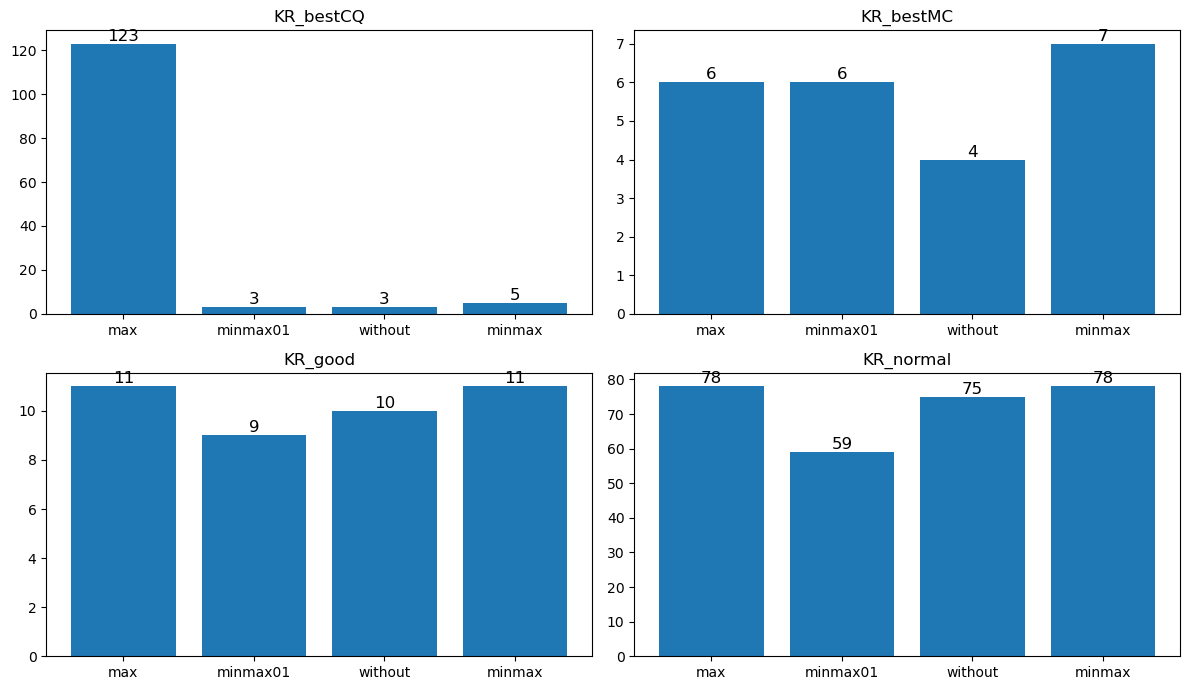

In [25]:
# 使用4个子图分别可视化不同normalized下的KR_bestCQ, KR_bestMC, KR_good, KR_normal

labels = ['max', 'minmax01', 'without', 'minmax']
KR_bestCQ_values = [max['KR_bestCQ'], minmax01['KR_bestCQ'], without['KR_bestCQ'], minmax['KR_bestCQ']]
KR_bestMC_values = [max['KR_bestMC'], minmax01['KR_bestMC'], without['KR_bestMC'], minmax['KR_bestMC']]
KR_good_values   = [max_good_normal['KR_good'],   minmax01_good_normal['KR_good'],   without_good_normal['KR_good'],   minmax_good_normal['KR_good']]
KR_normal_values = [max_good_normal['KR_normal'], minmax01_good_normal['KR_normal'], without_good_normal['KR_normal'], minmax_good_normal['KR_normal']]

fig, axs = plt.subplots(2, 2, figsize=(12, 7))
axs = axs.flatten()

# 子图1: KR_bestCQ
bars1 = axs[0].bar(labels, KR_bestCQ_values)
axs[0].set_title('KR_bestCQ')
for bar in bars1:
    height = bar.get_height()
    axs[0].text(bar.get_x() + bar.get_width()/2, height, f'{height}', ha='center', va='bottom', fontsize=12)

# 子图2: KR_bestMC
bars2 = axs[1].bar(labels, KR_bestMC_values)
axs[1].set_title('KR_bestMC')
for bar in bars2:
    height = bar.get_height()
    axs[1].text(bar.get_x() + bar.get_width()/2, height, f'{height}', ha='center', va='bottom', fontsize=12)

# 子图3: KR_good
bars3 = axs[2].bar(labels, KR_good_values)
axs[2].set_title('KR_good')
for bar in bars3:
    height = bar.get_height()
    axs[2].text(bar.get_x() + bar.get_width()/2, height, f'{height}', ha='center', va='bottom', fontsize=12)

# 子图4: KR_normal
bars4 = axs[3].bar(labels, KR_normal_values)
axs[3].set_title('KR_normal')
for bar in bars4:
    height = bar.get_height()
    axs[3].text(bar.get_x() + bar.get_width()/2, height, f'{height}', ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()



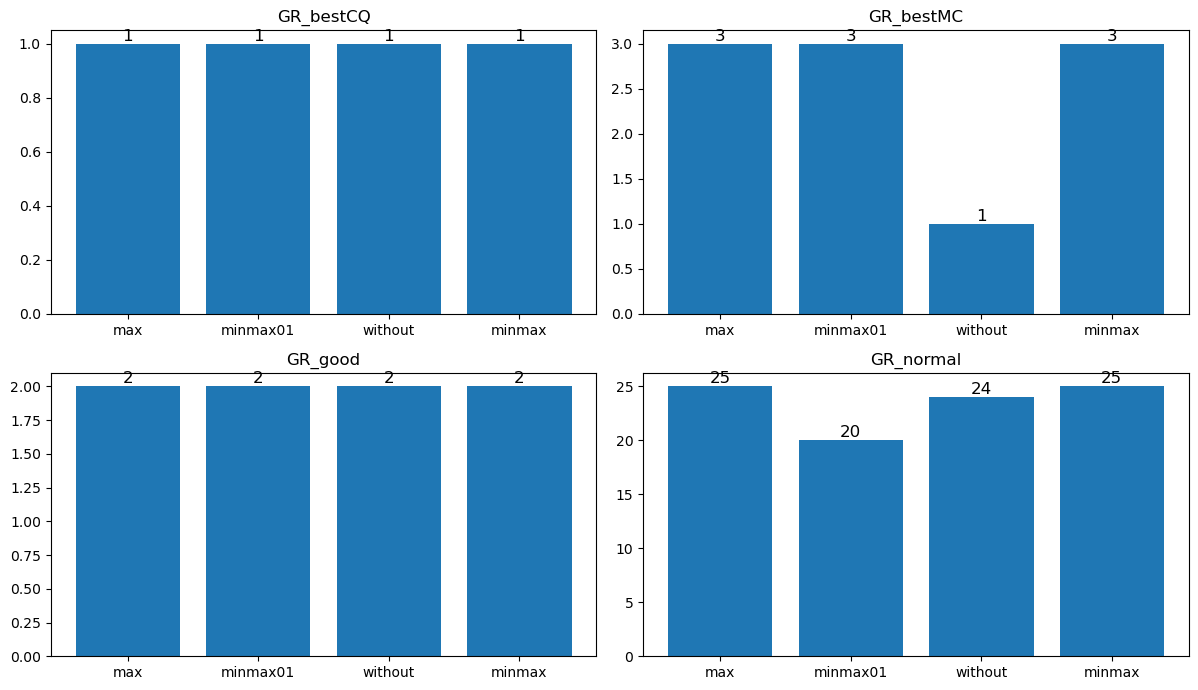

In [26]:
# 使用4个子图分别可视化不同normalized下的KR_bestCQ, KR_bestMC, KR_good, KR_normal

labels = ['max', 'minmax01', 'without', 'minmax']
KR_bestCQ_values = [max['GR_bestCQ'], minmax01['GR_bestCQ'], without['GR_bestCQ'], minmax['GR_bestCQ']]
KR_bestMC_values = [max['GR_bestMC'], minmax01['GR_bestMC'], without['GR_bestMC'], minmax['GR_bestMC']]
KR_good_values   = [max_good_normal['GR_good'],   minmax01_good_normal['GR_good'],   without_good_normal['GR_good'],   minmax_good_normal['GR_good']]
KR_normal_values = [max_good_normal['GR_normal'], minmax01_good_normal['GR_normal'], without_good_normal['GR_normal'], minmax_good_normal['GR_normal']]

fig, axs = plt.subplots(2, 2, figsize=(12, 7))
axs = axs.flatten()

# 子图1: KR_bestCQ
bars1 = axs[0].bar(labels, KR_bestCQ_values)
axs[0].set_title('GR_bestCQ')
for bar in bars1:
    height = bar.get_height()
    axs[0].text(bar.get_x() + bar.get_width()/2, height, f'{height}', ha='center', va='bottom', fontsize=12)

# 子图2: KR_bestMC
bars2 = axs[1].bar(labels, KR_bestMC_values)
axs[1].set_title('GR_bestMC')
for bar in bars2:
    height = bar.get_height()
    axs[1].text(bar.get_x() + bar.get_width()/2, height, f'{height}', ha='center', va='bottom', fontsize=12)

# 子图3: KR_good
bars3 = axs[2].bar(labels, KR_good_values)
axs[2].set_title('GR_good')
for bar in bars3:
    height = bar.get_height()
    axs[2].text(bar.get_x() + bar.get_width()/2, height, f'{height}', ha='center', va='bottom', fontsize=12)

# 子图4: KR_normal
bars4 = axs[3].bar(labels, KR_normal_values)
axs[3].set_title('GR_normal')
for bar in bars4:
    height = bar.get_height()
    axs[3].text(bar.get_x() + bar.get_width()/2, height, f'{height}', ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

我想看看normal的数据分布

max of outputs_normal 0.8860003024625226
min of outputs_normal -0.8863907524546611


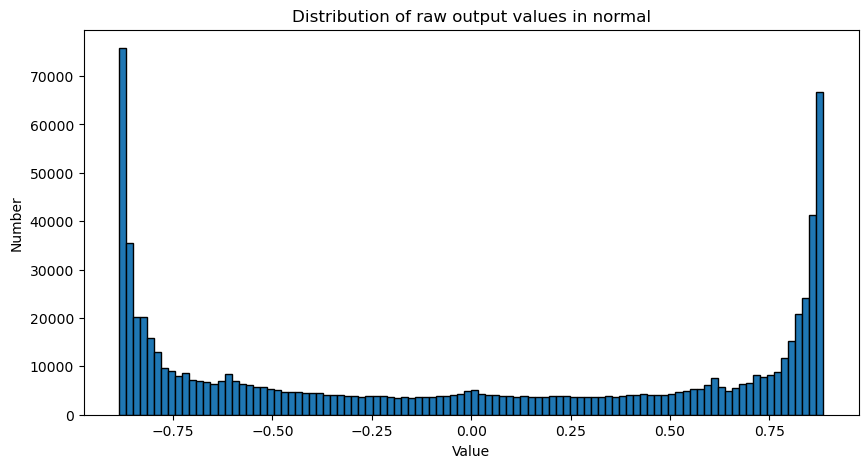

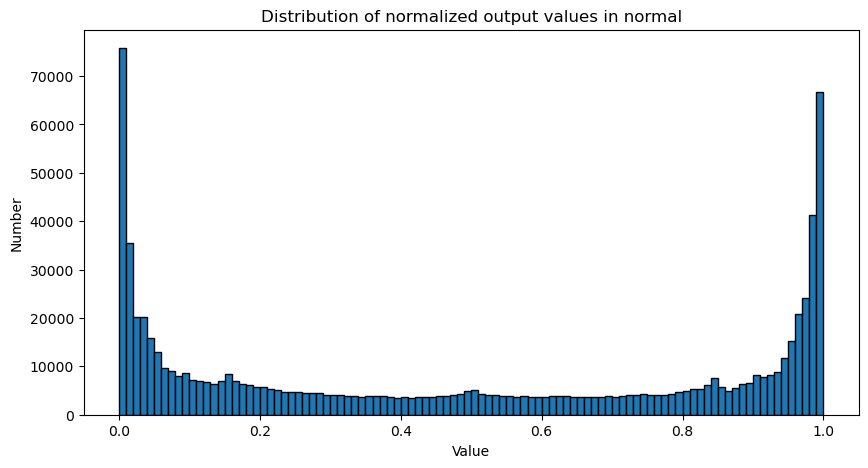

In [ ]:
# 我想了解outputs_normal中的元素数值分布，请用柱状图来表示元素的数值分布
# 将list转成numpy数组
outputs_normal= np.array(max_good_normal['outputs_normal'])
normalized_states_normal= np.array(max_good_normal['Normalized_States_normal'])

# 打印出outputs_bestCQ_array的最大值和最小值
print('max of outputs_normal',np.max(outputs_normal))
print('min of outputs_normal',np.min(outputs_normal))

plt.figure(figsize=(10, 5))
plt.hist(outputs_normal.flatten(), bins=100, edgecolor='black')
plt.ylabel('Number')
plt.xlabel('Value')
# x轴的刻度尺再细一点
plt.title('Distribution of raw output values in normal')
plt.show()

# States_bestCQ的分布
plt.figure(figsize=(10, 5))
plt.hist(normalized_states_normal.flatten(), bins=100, edgecolor='black')
plt.ylabel('Number')
plt.xlabel('Value')
plt.title('Distribution of normalized output values in normal')
plt.show()


max of outputs_good 0.6942929118482088
min of outputs_good -0.7971706680769995


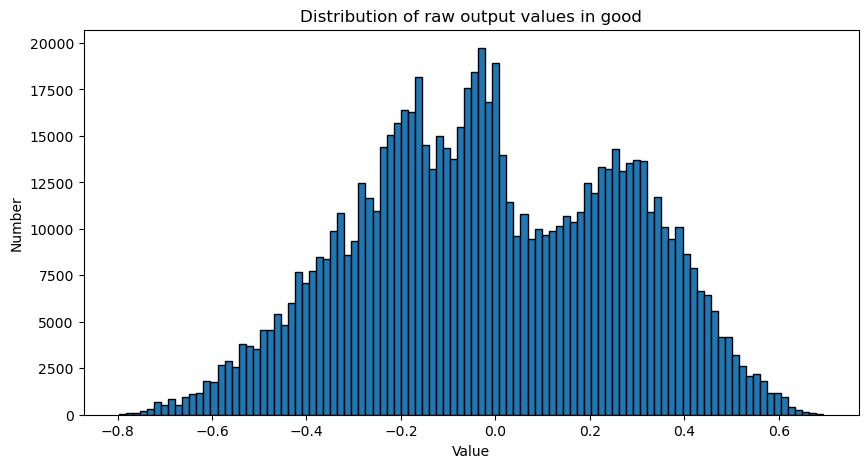

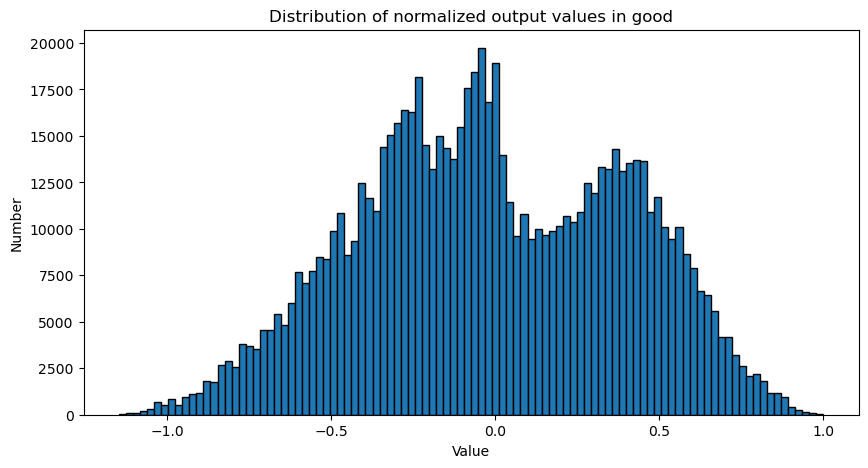

In [32]:
# 我想了解outputs_good中的元素数值分布，请用柱状图来表示元素的数值分布
# 将list转成numpy数组
outputs_good= np.array(max_good_normal['outputs_good'])
normalized_states_good= np.array(max_good_normal['Normalized_States_good'])

# 打印出outputs_bestCQ_array的最大值和最小值
print('max of outputs_good',np.max(outputs_good))
print('min of outputs_good',np.min(outputs_good))

plt.figure(figsize=(10, 5))
plt.hist(outputs_good.flatten(), bins=100, edgecolor='black')
plt.ylabel('Number')
plt.xlabel('Value')
# x轴的刻度尺再细一点
plt.title('Distribution of raw output values in good')
plt.show()

# States_bestCQ的分布
plt.figure(figsize=(10, 5))
plt.hist(normalized_states_good.flatten(), bins=100, edgecolor='black')
plt.ylabel('Number')
plt.xlabel('Value')
plt.title('Distribution of normalized output values in good')
plt.show()